# Example script to regrid CESM2 sea ice concentration to a regular 1$^\circ$x1$^\circ$ grid using xesmf

---

## Initial setup

### Start by loading appropriate packages

In [1]:
import xarray as xr
import numpy as np
import xesmf as xe
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

### Get historical sea ice concentration data from CESM2 for member r1i1p1f1

In [3]:
direc_i = '/Users/pade7652/Google Drive/CUBoulder/Projects/CESM2/Data/CESM2-CMIP6/' # Change to match the directory where your data is found
xdi = xr.open_dataset(direc_i+'siconc_SImon_CESM2_historical_r1i1p1f1_gn_185001-201412.nc',chunks={}) # The 'chunks' option above tells xarray to make this a dask array
print(xdi)

<xarray.Dataset>
Dimensions:    (d2: 2, ni: 320, nj: 384, nvertices: 4, time: 1980)
Coordinates:
    lat        (nj, ni) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    lon        (nj, ni) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * ni         (ni) int32 1 2 3 4 5 6 7 8 9 ... 313 314 315 316 317 318 319 320
  * nj         (nj) int32 1 2 3 4 5 6 7 8 9 ... 377 378 379 380 381 382 383 384
  * time       (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
Dimensions without coordinates: d2, nvertices
Data variables:
    siconc     (time, nj, ni) float32 dask.array<chunksize=(1980, 384, 320), meta=np.ndarray>
    time_bnds  (time, d2) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
    lat_bnds   (nj, ni, nvertices) float32 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
    lon_bnds   (nj, ni, nvertices) float32 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
Attributes: (12/45)
    Conventions:            CF-1.7 CMIP-6.2
    activity

<div class="admonition alert alert-warning">
    <p class="admonition-title" style="font-weight:bold">WARNING: If the coordinate variables are named something different than 'lat' and 'lon', rename them to 'lat' and 'lon' (see below).</p>
    Otherwise xesmf has no way of knowing what these are (it can't guess what your model's lat/lon coords are named). It can only recognize coordinates named 'lon' and 'lat'.
</div>

In [4]:
# xdi = xdi.rename({'latitude':'lat','longitude':'lon'})

### Select the 'siconc' variable

Can also select specific years and/or months at this point.

In [5]:
sic = xdi['siconc']
# sic = xdi['siconc'].sel({'time':slice('1980-01-01','2000-01-01')})
print(sic)

<xarray.DataArray 'siconc' (time: 1980, nj: 384, ni: 320)>
dask.array<open_dataset-49a09dc33c4112a84ad64670f8eb4236siconc, shape=(1980, 384, 320), dtype=float32, chunksize=(1980, 384, 320), chunktype=numpy.ndarray>
Coordinates:
    lat      (nj, ni) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    lon      (nj, ni) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * ni       (ni) int32 1 2 3 4 5 6 7 8 9 ... 313 314 315 316 317 318 319 320
  * nj       (nj) int32 1 2 3 4 5 6 7 8 9 ... 377 378 379 380 381 382 383 384
  * time     (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
Attributes: (12/19)
    cell_measures:  area: areacello
    cell_methods:   area: mean where sea time: mean
    comment:        Area fraction of grid cell covered by sea ice
    description:    Area fraction of grid cell covered by sea ice
    frequency:      mon
    id:             siconc
    ...             ...
    time_label:     time-mean
    time_title:     Temporal mean
    ti

### Plot the raw data

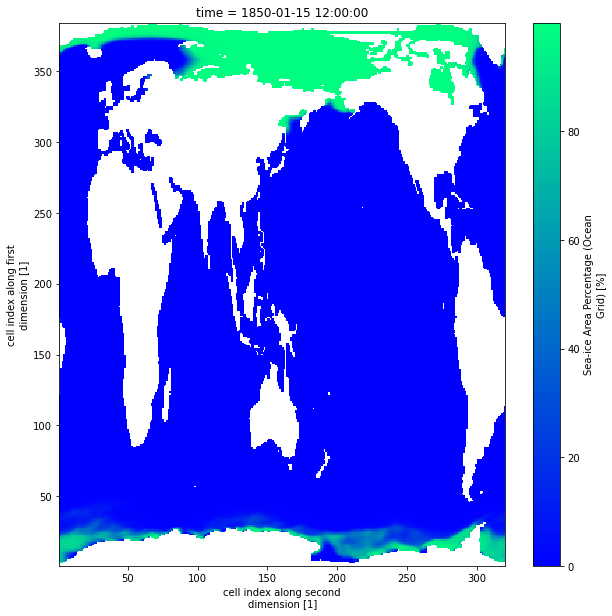

In [6]:
plt.figure(figsize=(10,10));
# ax = plt.axes(projection=ccrs.Robinson());
sic[0].plot.pcolormesh(x='ni',y='nj',cmap='winter');
# ax.coastlines();

You can see from the figure above that the data is not on a regular grid since the North Pole is over Greenland.

---

## Set up the regridder

### Define the target grid (the new grid you want your output on)

In [7]:
# In this case, we want to regrid to a 1 deg lat x 1 deg lon grid
lat = np.arange(-89.0,90.0,1.0) # Do not include 90S and 90N, it won't work because of the singularity at the poles
lon = np.arange(0.0,361.0,1.0) # cartopy gets rage-y (i.e. it doesn't work) when plotting
lon2d,lat2d = np.meshgrid(lon,lat)
target_grid = xr.Dataset({'lat': (['y', 'x'], lat2d),'lon': (['y', 'x'], lon2d)})
target_grid

<xarray.Dataset>
Dimensions:  (x: 361, y: 179)
Dimensions without coordinates: x, y
Data variables:
    lat      (y, x) float64 -89.0 -89.0 -89.0 -89.0 ... 89.0 89.0 89.0 89.0
    lon      (y, x) float64 0.0 1.0 2.0 3.0 4.0 ... 357.0 358.0 359.0 360.0

### Create regridding function

In [8]:
# Possible regridding algorithms. For a comparison of the different algorithms, check out: https://xesmf.readthedocs.io/en/latest/notebooks/Compare_algorithms.html
method_list = ['bilinear', 'conservative', 'nearest_s2d', 'nearest_d2s', 'patch']
# NOTE: Once you have the output of this (the weight file), you can set reuse_weights=True so that you don't need to recreate the weight file
regridder = xe.Regridder(sic, target_grid, method_list[2], periodic=True)

/Users/pade7652/opt/anaconda3/envs/regrid_env/lib/python3.7/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/Users/pade7652/opt/anaconda3/envs/regrid_env/lib/python3.7/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')


### Perform regridding

In [9]:
sic_rg = regridder(sic)
sic_rg

/Users/pade7652/opt/anaconda3/envs/regrid_env/lib/python3.7/site-packages/xesmf/frontend.py:478: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,


<xarray.DataArray 'siconc' (time: 1980, y: 179, x: 361)>
dask.array<transpose, shape=(1980, 179, 361), dtype=float64, chunksize=(1980, 179, 361), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
    lon      (y, x) float64 0.0 1.0 2.0 3.0 4.0 ... 357.0 358.0 359.0 360.0
    lat      (y, x) float64 -89.0 -89.0 -89.0 -89.0 ... 89.0 89.0 89.0 89.0
Dimensions without coordinates: y, x
Attributes:
    regrid_method:  nearest_s2d

---

## Plot regridded data

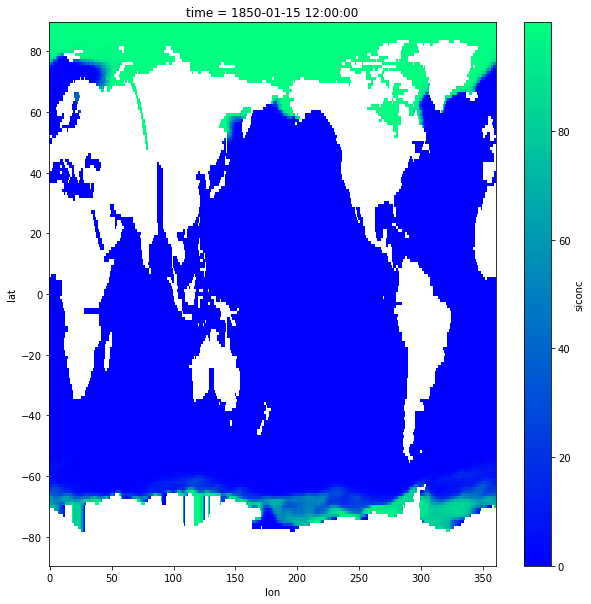

In [10]:
fig = plt.figure(figsize=(10,10));
# ax = fig.add_subplot(111)
sic_rg[0].plot.pcolormesh(x='lon',y='lat',cmap='winter');

---

## Save regridded data as a netCDF file

### Create output dataset

In [15]:
ds = xr.Dataset()
ds['siconc']      = (('time','y','x'),sic_rg)
ds.coords['lat']  = (('y','x'),sic_rg['lat'])
ds.coords['lon']  = (('y','x'),sic_rg['lon'])
ds.coords['time'] = (('time'),sic_rg['time'])

### Add whatever attributes you want to document your output

In [16]:
ds['siconc'].attrs['long_name'] = 'Sea Ice Concentration'
ds['siconc'].attrs['units']     = '%'
ds.attrs['model']               = 'CESM2'
ds.attrs['Description']         = 'historical siconc r1i1p1f1 regridded onto a rectilinear 1.0deg lat x 1.0deg lon grid'

### Set the missing and fill values to whatever they are in the original data

In [17]:
ds['siconc'].encoding['_FillValue']    = xdi['siconc'].encoding['_FillValue']
ds['siconc'].encoding['missing_value'] = xdi['siconc'].encoding['missing_value']

### Save as netCDF file

In [19]:
svdirec = '../Data/'
ds.to_netcdf(path=svdirec+'CESM2_siconc_hist_r1i1p1f1_xesmf_rg_1x1.nc')